#### PLATE LOCALIZATION

In [15]:
# dependences
import cv2
import imutils
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

In [16]:
def matrix_to_corners(matrix):
    """
    Convert a matrix to a list of corners
    """
    corners = []
    for i in range(0, 4):
        corners.append([matrix[i][0][0], matrix[i][0][1]])
    
    corners = np.array(corners)
    
    ordered = corners[corners[:, 0].argsort()]

    left_corners = ordered[:2]
    right_corners = ordered[2:]

    top_left = left_corners[left_corners[:, 1].argsort()][0]
    bottom_left = left_corners[left_corners[:, 1].argsort()][1]

    top_right = right_corners[right_corners[:, 1].argsort()][0]
    bottom_right = right_corners[right_corners[:, 1].argsort()][1]

    return [list(top_left), list(top_right), list(bottom_left), list(bottom_right)]

In [17]:
def DetectPlateContour(image):

    image = imutils.resize(image, width=1100)
    image_original = image.copy()

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.bilateralFilter(gray_image, 11, 17, 17) 

    edged = cv2.Canny(gray_image, 30, 200) 

    cnts,new = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    cnts = sorted(cnts, key = cv2.contourArea, reverse = True) [:30]


    screenCnt = 0
    for c in cnts:
        perimeter = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)
        x,y,w,h = cv2.boundingRect(c)

        epsilon= 2
        if len(approx) == 4 and abs((w/h)- 340/110) < epsilon: 
            screenCnt = approx

            break

    if type(screenCnt) != int:
        print(type(screenCnt))
        cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 3)
        corners = matrix_to_corners(screenCnt)
        return corners, image_original

    else:
        return None, image_original      

In [18]:
def GeometricTransformation(xx, xy, yx, yy, image):
    # xx: adalt esquerre (1) min, min
    # xy: adalt dreta (2)
    # yx: abaix esquerra (3)
    # yy: abaix dreta (4)
    #----------

    # Los parámetros que debemos especificar son:
    #Coordenadas de los 4 puntos correspondientes a los vértices cuadrangulares de la imagen de entrada. (source)
    #Coordenadas de los 4 puntos correspondientes a los vértices cuadrangulares fijos de la imagen de destino. (destination).
    source= np.float32([xx, xy, yx, yy]) 
    destination = np.float32([[0,0], [340, 0], [0,110],  [340,110]]) #puntos en la nueva imágen de referencia
    
    # getPerspectiveTransform: función que calcula la transformación de perspectiva a partir de 4 pares de puntos, por lo tanto de esta se obtendrá una matriz de 3×3
    M = cv2.getPerspectiveTransform(source, destination) 
    

    # warpPerspective. función que aplica la transformación de perspectiva sobre la imágen
        #Imagen de entrada
        #M, matriz de transformación de 3×3.
        #Tamaño de la imagen de salida (Matriculas son de 340 x 110)

    img_dst = cv2.warpPerspective(image, M, (340,110))

    print(type(img_dst))

    return img_dst

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


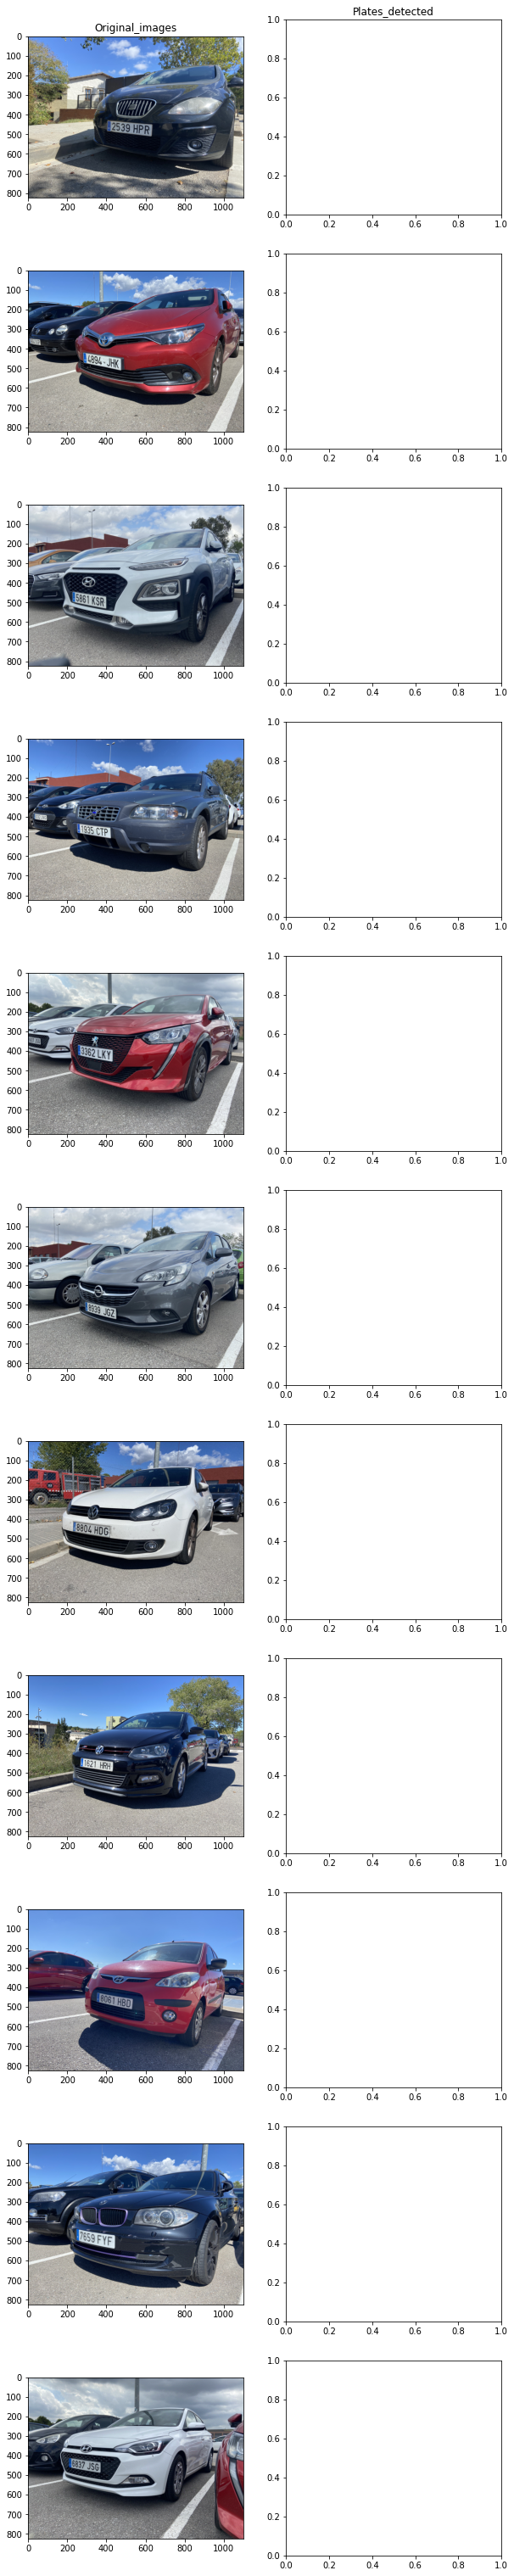

In [19]:
def plate_localization(folder_origin, folder_destination, plot=False):
    files = os.listdir(folder_origin)
    if plot:
        fig, ax = plt.subplots(len(files), 2, figsize=(10, 5*len(files)))
        ax[0, 0].set_title("Original_images")
        ax[0, 1].set_title("Plates_detected")

    for filename in os.listdir(folder_origin):
        if filename.endswith(".jpg"): 

            image = cv2.imread(os.path.join(folder_origin,filename))
            corners, image_original = DetectPlateContour(image)
            if plot:
                ax[files.index(filename)][0].imshow(cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))

            # if corners:
            #     img_dst = GeometricTransformation(corners[0], corners[1], corners[2], corners[3], image_original)
            #     cv2.imwrite(os.path.join(folder_destination,filename[:-4]+"_localization.jpg"), img_dst)
            #     if plot:
            #         ax[files.index(filename)][1].imshow(cv2.cvtColor(img_dst, cv2.COLOR_BGR2RGB))
                    
                
            #     print(f"Image {filename} processed")

            # else:
            #     print(f"Image {filename}: No plate detected")

    # save as file
    plt.show()

plate_localization("images/raw_images/", "", plot=True)

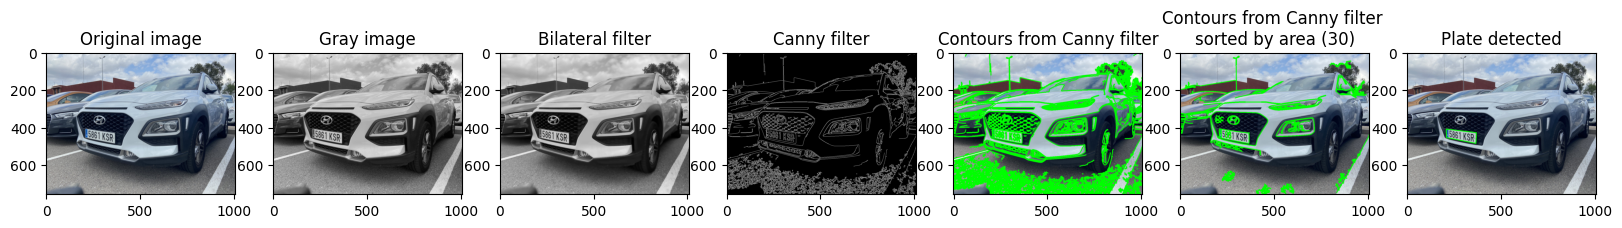

In [18]:
def display_process(file):

    fig, ax = plt.subplots(1, 7)
    fig.set_size_inches(20, 10)

    img = cv2.imread(file)

    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original image")

    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ax[1].imshow(gray_image, cmap='gray')
    ax[1].set_title("Gray image")

    gray_image = cv2.bilateralFilter(gray_image, 11, 17, 17) 

    ax[2].imshow(gray_image, cmap='gray')
    ax[2].set_title("Bilateral filter")

    edged = cv2.Canny(gray_image, 30, 200) 

    ax[3].imshow(edged, cmap='gray')
    ax[3].set_title("Canny filter")

    cnts,new = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    img_contours = img.copy()
    cv2.drawContours(img_contours, cnts, -1, (0, 255, 0), 3)

    ax[4].imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
    ax[4].set_title("Contours from Canny filter")
    
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True) [:30]

    img_contours_30 = img.copy()
    cv2.drawContours(img_contours_30, cnts, -1, (0, 255, 0), 3)

    ax[5].imshow(cv2.cvtColor(img_contours_30, cv2.COLOR_BGR2RGB))
    ax[5].set_title("Contours from Canny filter \nsorted by area (30)")

    screenCnt = 0
    for c in cnts:
        perimeter = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.018 * perimeter, True)
        x,y,w,h = cv2.boundingRect(c)

        epsilon= 2
        if len(approx) == 4 and abs((w/h)- 340/110) < epsilon: 
            screenCnt = approx

            break

    if type(screenCnt) != int:
        cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 3)
        corners = matrix_to_corners(screenCnt)

        ax[6].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[6].set_title("Plate detected")


    plt.savefig('plate_localization_process.png')
    plt.show()


display_process("fotos/IMG_4344.jpg")

    